MSE: 1.1536
MAE: 0.6915
R-Squared: -0.0925


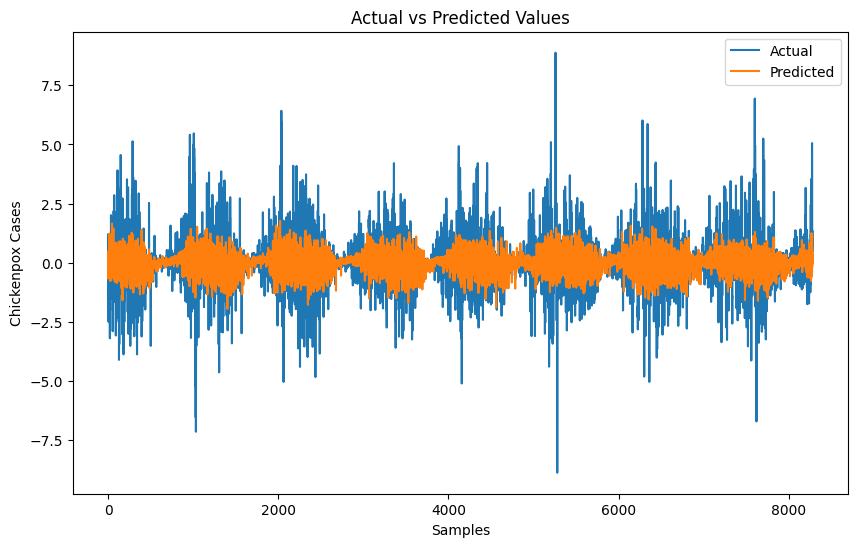

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GCLSTM
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Load dataset
loader = ChickenpoxDatasetLoader()
dataset = loader.get_dataset()

# Split into training and testing sets
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GCLSTM(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

# Initialize model
model = RecurrentGCN(node_features=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training
model.train()
for epoch in range(500):
    cost = 0
    h, c = None, None
    for time, snapshot in enumerate(train_dataset):
        y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

# Evaluation
model.eval()
predictions = []
actuals = []
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
    predictions.append(y_hat.detach().numpy())
    actuals.append(snapshot.y.numpy())
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()

# Print MSE
print("MSE: {:.4f}".format(cost))

# Convert predictions and actuals to numpy arrays
predictions = np.concatenate(predictions).flatten()
actuals = np.concatenate(actuals).flatten()

# Calculate MAE and R-Squared
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f"MAE: {mae:.4f}")
print(f"R-Squared: {r2:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.title("Actual vs Predicted Values")
plt.xlabel("Samples")
plt.ylabel("Chickenpox Cases")
plt.legend()
plt.show()
